# Practical Session 6 : More on Segmentation

Vrushank Agrawal

In this practical session, we you will have to implement :

- Fuzzy C-means
- EM algorithm **OR** Growing Regions

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from scipy import ndimage
from scipy.interpolate import griddata
from scipy.spatial.distance import cdist
from skimage.color import rgb2gray
import matplotlib
import numpy.matlib
%matplotlib inline

In [5]:
# Run this the first time you launch the kernel on Colab.
! git clone https://github.com/AgatheSenellart/DataMAA308.git
! mv DataMAA308/data data
! mv DataMAA308/Images Images 

Cloning into 'DataMAA308'...
remote: Enumerating objects: 461, done.
remote: Total 461 (delta 0), reused 0 (delta 0), pack-reused 461
Receiving objects: 100% (461/461), 98.68 MiB | 27.79 MiB/s, done.
Resolving deltas: 100% (13/13), done.


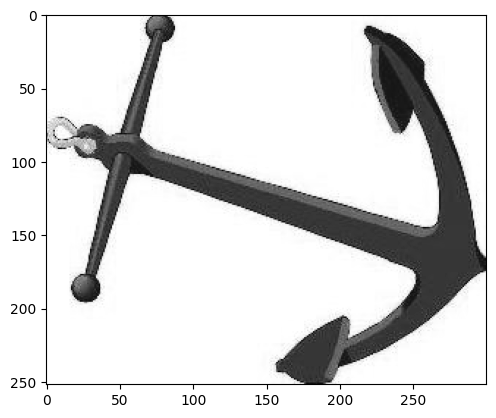

In [6]:
windmill = mpimg.imread('Images/windmill.png') 
anchor = mpimg.imread('Images/image_redanch.jpg') 
I = anchor
I_gray = rgb2gray(I)
plt.imshow(I_gray,cmap='gray')

# Fuzzy C-means

Recall that for the Fuzzy C-means algorithm, we aim at computing probabilities $u_{s,k}$ for each pixel $s$ to belong to each cluster $k$.

- Randomly initialize centers $\mu_k$ for $k \in [1,k|]$
- Define the probability of pixel $s$ to belong to cluster $k$ as : $u_{s,k} = \left (\sum_{j=1}^{K} \left( \frac{||x_s - \mu_k||}{||x_s - \mu_j||} \right)^{\frac{2}{m-1}} \right)^{-1}$
- Update the centers $\mu_k = \sum_{s = 1}^{S} (u_{s,k})^{m} x_s / \sum_{s = 1}^{S} (u_{s,k})^{m} $
- Repeat the two steps above until convergence.

**TODO 1** : 

Implement Fuzzy C-means algorithm and test it on the different provided images. Read carefully the function description to see what it should return.

In [60]:
def compute_u(I, centers, m):
    dist = np.abs(I[:, :, None, ...] - centers)  # Compute element-wise absolute differences
    dist = dist.sum(axis=-1) ** (2/(m-1))
    u_sk = 1/(dist * np.sum(1 / dist, axis=-1)[..., None] + 1e-10) # add minor error to avoid division by 0
    return u_sk

def update_centers(I, u_sk, m):
    u_sk_m = u_sk ** m
    centers = np.sum(u_sk_m[..., None] * I[:, :, None, ...], axis=(0, 1))  # Compute weighted sums
    centers /= np.sum(u_sk_m, axis=(0, 1))[..., None]  # Compute normalized centers
    return centers

def fuzzy_cmeans(image,n_clusters,m=2):
    
    '''
    Implement fuzzy C-means algorithm. 
    
    Args : 
        image : (nr,nc) for grey images or (nr,nc,3) for colors images
        n_clusters (int) : the number of clusters we consider. 
        m (int) : the hyperparameter m of Fuzzy C-Means. Default to 2. 
        
    Returns :
        labels : array the same shape as image that contains for each 
            pixel, the cluster it belongs to.
        centers : array of size (k,) that contains the final center values. 
    
    '''
    nr, nc, nc_channels = image.shape
    centers = np.random.rand(n_clusters, 3)
    old_centers = np.inf * np.ones_like(centers)
    labels = np.zeros_like(image)
    epsilon = 1e-6

    for i in range(100):
        if np.linalg.norm(centers-old_centers) < epsilon:
            break  
        old_centers = centers
        u_sk = compute_u(I, centers, m)
        labels = np.argmax(u_sk, -1)
        centers = update_centers(I, u_sk, m)
    
    return labels,centers

Run the algorithm implementation on the image I.

In [61]:
n_clusters = 2
labels,centers = fuzzy_cmeans(I,n_clusters=n_clusters)
print(labels.shape)
print(len(centers))

(252, 300)
2


(252, 300)
(252, 300, 3)


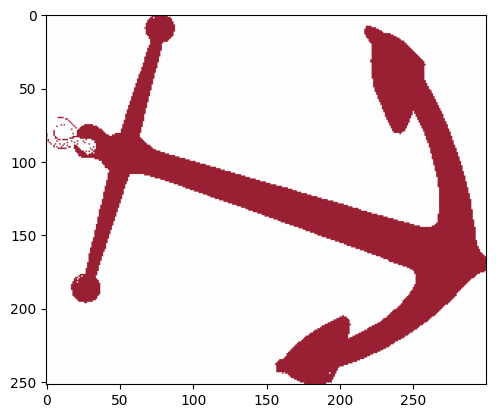

In [63]:
# Simple test on the outputs :
assert labels.shape[:2] == I.shape[:2]
assert n_clusters == len(centers)

print(labels.shape)
print(I.shape)

image_clust = I * 0
for k in range(len(centers)):
    image_clust[labels == k] = centers[k]
plt.imshow(image_clust)

**TODO 2** : Implement either the EM algorithm or the Growing region algorithm. 

# EM algorithm to estimate a Gaussian Mixture Model (GMM)

In a Gaussian Mixture Model, we make the assumption that the observations $(y_i)_{1 \leq i \leq M}$ are sampled from a latent variable model with parameter $\theta$ that we aim to estimate. 

The model is the following; 

- For all $i \in [|1,M|]$, a latent variable  $z_i$ is sampled from a Multinomial distribution ($p(z_i = k) = \pi_k)$ for $1 \leq k \leq K$). 

- Then, knowing that $z_i = k$, $y_i$ is sampled from $(y_i |z_i=k) \sim \mathcal{N}(\mu_k,\Sigma_k)$

- We aim to estimate $\theta = (\pi, \mu,\Sigma)$ that maximizes the likelihood of all the observations $\sum_{i=1}^{M} \log p(y_i ; \theta)$

Since the likelihood is intractable we use the Expectation-Maximization Algorithm. We update $\theta_t$ iteratively until convergence.

- **Initialization** : There are different possibilities for the initialization but a possible one is to initialize the algorithm
with the results of the K-means clustering (implemented in the last practical session). Take for all $1 \leq k \leq K$ : $\mu_k$ the center of the k-th cluster of K-means, $\Sigma_k$ the variance of pixel values in that cluster, and $\pi$ to be the uniform distribution.

- **Expectation Step** :
Given a value $\theta_t$ : for each $i \in [|1, M|]$ compute the distribution $p(z_i|y_i; \theta_t)$. It is a discrete distribution, so you need to compute $s_{i,k}^{(t)} = p(z_i = k|y_i; \theta_t)$ for $1 \leq k \leq K$.

- **Maximisation Step** :
Using the distributions $p(z_i|y_i; \theta_t)$ that you computed in the E-step, compute $$\theta_{t+1} = \argmax_{\theta} \sum_{i=1}^{M} \sum_{k=1}^{K} p(y_i,z_i=k;\theta)p(z_i=k|y_i;\theta_t) = \argmax_{\theta}\sum_{i=1}^{M} \sum_{k=1}^{K} p(y_i,z_i=k;\theta)s_{i,k}^{(t)}$$To do so : compute and cancel the gradients of the above function with regard to the parameters $\mu_k, \Sigma_k, \pi$. 

At the end of the EM optimization, you have the clusters centers $\mu_k^{(t)}$, and the probabilities for sample i to belong to cluster k in $s_{i,k}^{(t)}$.


In [ ]:
# We provide you here with the k_means function that you can use for the initialization of EM. 
def k_means(image,k=2):
    if image.ndim==2:
        pixel_values = I[...,np.newaxis].copy()
    else :
        pixel_values = image.copy()
        
    nr,nc,d = pixel_values.shape
    pixel_values = pixel_values.reshape((-1,d))

    #Random clusters
    index_centers = np.random.randint(low = 0, high = len(pixel_values),size = k)
    centers = np.asarray(pixel_values[index_centers])
    
    
    stable_labels = False
    iteration = 0
    
    old_labels = np.zeros((len(pixel_values)))
    
    while not(stable_labels) :
        
        iteration+=1
        
        # Calculate distance of points to centers of classes
        Dist_c = cdist(pixel_values,centers,metric = 'minkowski')
        
        
        # Assign each point to the nearest class
        labels = np.argmin(Dist_c,axis=1)

        # Calculate new means of each class to be centroids of classes
        for i in range(k) :
            centers[i,:] = np.mean(pixel_values[labels == i],axis=0)
            
        
        stable_labels  = (labels == old_labels).all()
        old_labels = labels.copy()
        
        
  
    return labels,centers

**EM : TODO 1 : Expectation step**

- For all $1 \leq i \leq M$ and $1 \leq k \leq K$, give the analytical expression of $s_{i,k}^{(t)} = p(z_i = k|y_i; \theta_t)$
- Implement the E-step described before. 

In [ ]:
from scipy.stats import multivariate_normal

def E_step(pixels_values, mu_t, sigma_t, pi_t, k) :
    '''
    Performs the E-step. Given mu, sigma, pi from previous iteration, returns the values of s_ik values.
    Inputs :
    
        - pixels_values (array (n,d)) : all n pixels values. For a gray image d = 1, for an RGB image d = 3.
        - mu_t (array (k,d)) : the means for all k clusters at iteration t.
        - sigma_t (array (k,d,d)) : the covariances for all k clusters at iteration t.
        - pi_t (array (k)) : the clusters' probabilities at iteration t. 
        - k (int) : the number of clusters.
        
    returns :
        s : array (k,n). The values of s_ik for all clusters and all observations. 
        L : float : The mean-log-likelihood of observations given mu_t, sigma_t,pi_t
        
    '''
    n, d = pixels_values.shape
    s = np.zeros((k, n))
    L = 0

    for i in range(k) :
        s[i,:] = pi_t[i]*multivariate_normal.pdf(pixels_values, mean = mu_t[i,:], cov = sigma_t[i,:,:])

    s = s/np.sum(s,axis=0)
    L = np.mean(np.log(np.sum(s,axis=0)))

    return s, L

**EM : TODO 2 : M-Step** : 

- Compute and give the analytical expressions of $\mu_{t+1}$, $\Sigma_{t+1}$ and $\pi_{t+1}$ from the M-Step optimization.
- Complete the function below to implement the M-Step.

In [ ]:
def M_step(pixel_values, s_t, mu_t, sigma_t, pi_t, k):
    '''
    Performs the M-step. 
    
    Inputs : 
        pixels_values (array (n, d)) 
        s_t (array (k,n)) : The s_ik values after the E-step
        mu_t (array (k, d)) : The means of the clusters at the previous iteration.
        sigma_t (array (k, d, d)) : The covariances of the clusters at the previous iteration. 
        pi_t (array (k)) : The clusters' probabilities at the previous iteration.
        k (int) : the number of clusters. 
        
    Returns : 
        mu, sigma, pi : the updated values after the M-step. 
    '''
    n, d = pixel_values.shape
    mu = np.zeros((k, d))
    sigma = np.zeros((k, d, d))
    pi = np.zeros((k))

    for i in range(k) :
        mu[i,:] = np.sum(s_t[i,:]*pixel_values.T,axis=1)/np.sum(s_t[i,:])
        sigma[i,:,:] = np.dot((s_t[i,:]*pixel_values.T-mu[i,:]).T,(s_t[i,:]*pixel_values.T-mu[i,:]))/np.sum(s_t[i,:])
        pi[i] = np.sum(s_t[i,:])/n
    
    return mu, sigma, pi

**EM : TODO 3: Putting everything together** :

- Use the previous functions to implement the entire EM algorithm. 
- Stop iterating when the likelihood values between two steps become very close. 

In [ ]:
def EM(image,k) :
    '''
    
    Performs the EM estimation of the Gaussian Mixture Model on the pixel values of image
    for k clusters. 
    
    inputs: 
        image (array (nr,nc,d)) : d = 1 for a gray image or 3 for an RGB image.
        k (int) : the number of clusters to consider. 
        
    Returns :
        labels_EM : array (nr, nc) that contains the most probable cluster for each pixel
        mu : array (k,d) : The final means of the clusters after EM.
        sigma : array (k,d,d): The final covariances of the clusters.
        pi : array (k): The final clusters' probabilities
        s : array (n,k) : The final probabilities for each sample to belong to each cluster. 
        
    
    '''
    if image.ndim==2:
        pixel_values = image[...,np.newaxis].copy()
    else :
        pixel_values = image.copy()

    nr,nc,d = pixel_values.shape
    pixel_values = pixel_values.reshape((-1,d))
    n = len(pixel_values)

    #Random clusters
    index_centers = np.random.randint(low = 0, high = len(pixel_values),size = k)
    mu = np.asarray(pixel_values[index_centers])
    sigma = np.zeros((k,d,d))
    for i in range(k) :
        sigma[i,:,:] = np.identity(d)
    pi = np.ones((k))/k
    
    stable = False
    iteration = 0
    old_L = -np.inf
    while not(stable) :
        iteration+=1
        s,L = E_step(pixel_values,mu,sigma,pi,k)
        mu,sigma,pi = M_step(pixel_values,s,mu,sigma,pi,k)
        stable = (L-old_L) < 1e-3
        old_L = L
        print('Iteration : ',iteration,' Mean-Log-Likelihood : ',L)

    labels_EM = np.argmax(s,axis=0).reshape((nr,nc))
    
    return labels_EM,mu,sigma,pi,s

In [ ]:
# Run EM 
print(I.shape)
labelsEM,centers,sigma,pi,responsibilities = EM(I,k=3)

(252, 300, 3)


<ipython-input-42-c4c15c8eb375>:26: RuntimeWarning: invalid value encountered in true_divide
  s = s/np.sum(s,axis=0)


ValueError: ignored

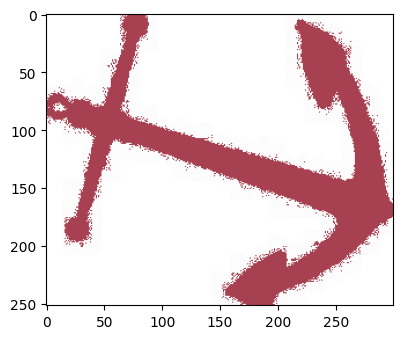

In [ ]:
# Plot the result
image_clust = I.copy()
for k in range(len(centers)):
    image_clust[labelsEM==k] = centers[k]
plt.imshow(image_clust,cmap='gray')

# Growing Region segmentation

In this part, you need to implement the growing region algorithm. 

The Growing Region algorithm needs *seeds* to begin with. 
In the cell below, you can select seeds interactively in a pop-up window if you have Tkinter installed. Else, you can use the next cell to select manually enters seeds' coordinates. 


In [ ]:
matplotlib.use( 'TkAgg' )

n_regions = 2

def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

plt.clf()
plt.imshow(I_gray,cmap='gray')

tellme('You will define markers, click to begin')
plt.waitforbuttonpress()



while True:

    seeds = None    
    for lab in range(1,n_regions+1):
        pts = []
         
        tellme('Select markers for label %d' % lab)
        pts = np.asarray(plt.ginput(1, timeout=-1))


        if seeds is None :
            seeds = np.rint(pts).copy()
        else :
            seeds = np.append(seeds, np.rint(pts), axis=0)

   
    seeds = seeds.astype(int)

    tellme('Happy? Press Enter on keyboard for yes, mouse click for no')
    if plt.waitforbuttonpress():
        break
        
seeds[:,[1,0]] = seeds[:,[0,1]]



ImportError: ignored

If the cell above doesn't work, use the next one to select the seeds' coordinates.

(1, 2)


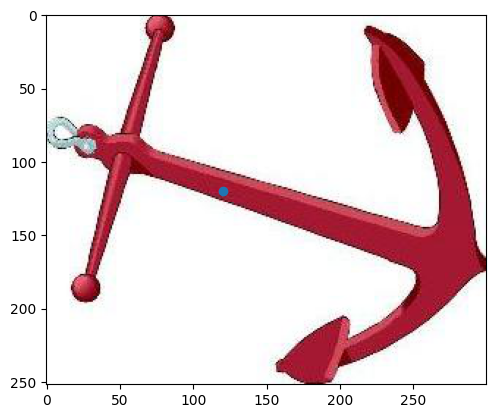

In [7]:
# Choose seeds : manually enter the seeds coordinates you want to use
seeds = np.array([
    # [10,10],
    [120,120]
    ])
print(seeds.shape)
# Visualize the seeds
plt.imshow(I)
plt.scatter(seeds[:,0],seeds[:,1])

**Growing Region TODO 1** 

- Implement the growing region algorithm. 
- For each seed :
    - Look at the neighbors : if their intensity is close to the region's one, add them to the region. 
    **Specify explicitly which criterion you are using for adding a pixel to the region**. For instance, you've
    seen two possible criterias in the lecture's slides.
    - Repeat for the neighbors of added pixels until the region stops growing. 

In [13]:

def growing_region(seeds,image,threshold = 0.05):
    """Implements the growing region algorithm. 

    Args:
        seeds (array (n,2)): The coordinates of the n seeds. 
        image (array (nr,nc,d)): The input image. d=1 if gray image else 3. 
        threshold (float, optional): The threshold for adding a pixel in the region. Defaults to 0.05.

    Returns:
        regions : array (nr,nc) The array containing for each pixel the region it belongs to
            if it belongs to one. 
    """
     
    nr, nc = image.shape
    regions = np.zeros((nr, nc))

    for seed in seeds:
        stack = [seed]
        region_intensity = image[seed[0], seed[1]]

        while stack:
            x, y = stack.pop()

            # the criterion is the intesity based criterion which checks the
            # extrema of the regions in comparison to the provided threshold
            if (x >= 0 and x < nr) \
              and (y >= 0 and y < nc) \
              and regions[x, y] == 0 \
              and np.abs(image[x, y] - region_intensity) <= threshold:
                    regions[x, y] = 1
                    stack.append((x + 1, y))
                    stack.append((x - 1, y))
                    stack.append((x, y + 1))
                    stack.append((x, y - 1))

    return regions

In [14]:
# Run the algorithm on a test image. 
reg = growing_region(seeds,I_gray,threshold=0.04)

Plot the image. 
Depending on the seed and the criterion that you used for extending the regions, you may not obtain the same result as below but it doesn't mean it is wrong!

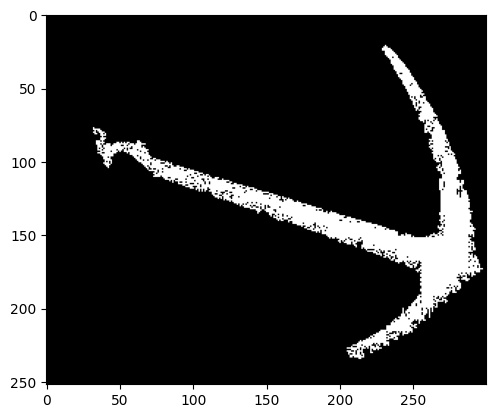

In [15]:
plt.imshow(reg,cmap='gray')
plt.show()